In [1]:
#!pip install yfinance
#!pip install hmmlearn
#pip install arch
#pip install scipy
#pip install --upgrade --user hmmlearn
#pip install --user git+https://github.com/hmmlearn/hmmlearn
from sklearn.mixture import GaussianMixture
import yfinance as yf
import numpy as np
from numpy import random
import pandas as pd
from scipy.stats import norm
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score 
from hmmlearn import hmm
from hmmlearn.hmm import GaussianHMM 
import matplotlib.pyplot as plt
import statsmodels.api as sm
#from arch import arch_model
from scipy.stats import chi2, t, norm
from datetime import datetime
from itertools import product
from arch import arch_model

Data collection

In [2]:
ticker = "^GSPC"  #S&P 500 index symbol
daily = yf.download(ticker, start="1950-01-01", end="2024-11-30", interval="1d")
#daily.loc[(daily['Open'] == 0) & (daily.index >= '1961-12-29') & (daily.index <= '1982-04-20'), 'Open'] = np.nan
#Before 29th Dec 1961, same values in the row
#Between 29th Dec 1961 and 20th April 1982, "Open" set to 0

daily = daily[daily.columns[0:4]]

[*********************100%%**********************]  1 of 1 completed


c:\Users\graci\anaconda3\Lib\site-packages\yfinance\utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [3]:
# Resample the data to monthly frequency
monthly = daily.resample('MS').agg({'Open': 'first','High': 'max','Low': 'min','Close': 'last'})
monthly = monthly.dropna()
monthly_with_dates = monthly

# Reset the index to have 'Date' as a column
monthly = monthly.reset_index()

<Axes: >

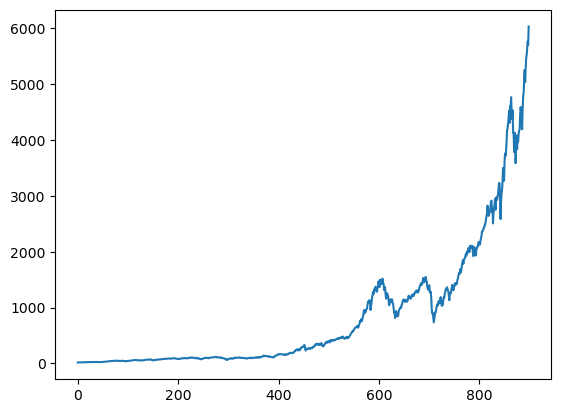

In [4]:
monthly['Close'].plot()

Test for stationarity 

In [5]:
True_price = monthly_with_dates['Close']
print(True_price.shape)

(899,)


In [6]:
True_price

Date
1950-01-01      17.049999
1950-02-01      17.219999
1950-03-01      17.290001
1950-04-01      17.959999
1950-05-01      18.780001
                 ...     
2024-07-01    5522.299805
2024-08-01    5648.399902
2024-09-01    5762.479980
2024-10-01    5705.450195
2024-11-01    6032.379883
Freq: MS, Name: Close, Length: 899, dtype: float64

In [7]:
sm.tsa.stattools.adfuller(True_price, regression='n', autolag='BIC', store=False, regresults=True)

(5.530603168749355,
 1.0,
 {'1%': -2.5682738268565344,
  '5%': -1.941308107020567,
  '10%': -1.616522983799078},
 <statsmodels.stats.diagnostic.ResultsStore at 0x253f04dd880>)

In [8]:
sm.tsa.stattools.adfuller(True_price, regression='c', autolag='BIC', store=False, regresults=True)

(4.977697371218509,
 1.0,
 {'1%': -3.4377689935918783,
  '5%': -2.864815046188292,
  '10%': -2.5685138660653957},
 <statsmodels.stats.diagnostic.ResultsStore at 0x253f04dd040>)

In [9]:
sm.tsa.stattools.adfuller(True_price, regression='ct', autolag='BIC', store=False, regresults=True)
#we cannot reject H0 which means that the TS is stationary

(3.531259545130856,
 1.0,
 {'1%': -3.969047635796577,
  '5%': -3.415468144550754,
  '10%': -3.1299799419503365},
 <statsmodels.stats.diagnostic.ResultsStore at 0x253f8aba8d0>)

In [10]:
True_price_diff = True_price.diff().dropna()  #we differenciate the TS to make it stationnary


In [11]:
sm.tsa.stattools.adfuller(True_price_diff, regression='n', autolag='BIC', store=False, regresults=True)

(-5.718159037552288,
 3.7035690751270905e-08,
 {'1%': -2.5682567137987626,
  '5%': -1.941306001663903,
  '10%': -1.6165249633898795},
 <statsmodels.stats.diagnostic.ResultsStore at 0x253f7e22ff0>)

In [12]:
sm.tsa.stattools.adfuller(True_price_diff, regression='ct', autolag='BIC', store=False, regresults=True)


(-6.667193399524685,
 7.882817558709957e-08,
 {'1%': -3.9689781021789607,
  '5%': -3.415434505721528,
  '10%': -3.1299601554678294},
 <statsmodels.stats.diagnostic.ResultsStore at 0x253f8ab87a0>)

In [13]:
sm.tsa.stattools.adfuller(True_price_diff, regression='ct', autolag='BIC', store=False, regresults=True)
#now it is stationnary

(-6.667193399524685,
 7.882817558709957e-08,
 {'1%': -3.9689781021789607,
  '5%': -3.415434505721528,
  '10%': -3.1299601554678294},
 <statsmodels.stats.diagnostic.ResultsStore at 0x253f8abbcb0>)

Check for serial dependance in the white noise

In [14]:
#===========================================================================
# Ljung-Box test to check whether my time series is a White Noise
#===========================================================================
#so there is autocorrelations in the residuals

n_autocor = 5
sm.stats.diagnostic.acorr_ljungbox(True_price_diff, lags=[n_autocor])

,lb_stat,lb_pvalue
5,25.889188,0.000094


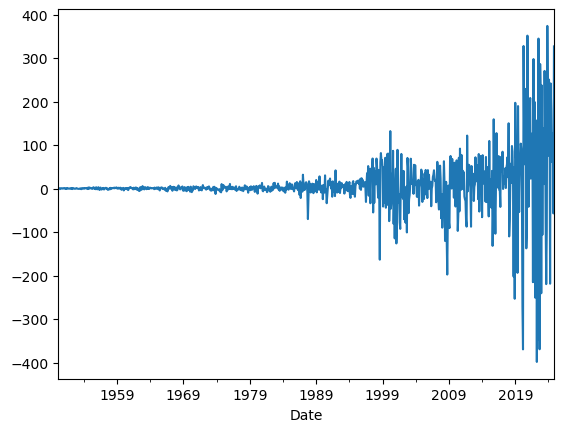

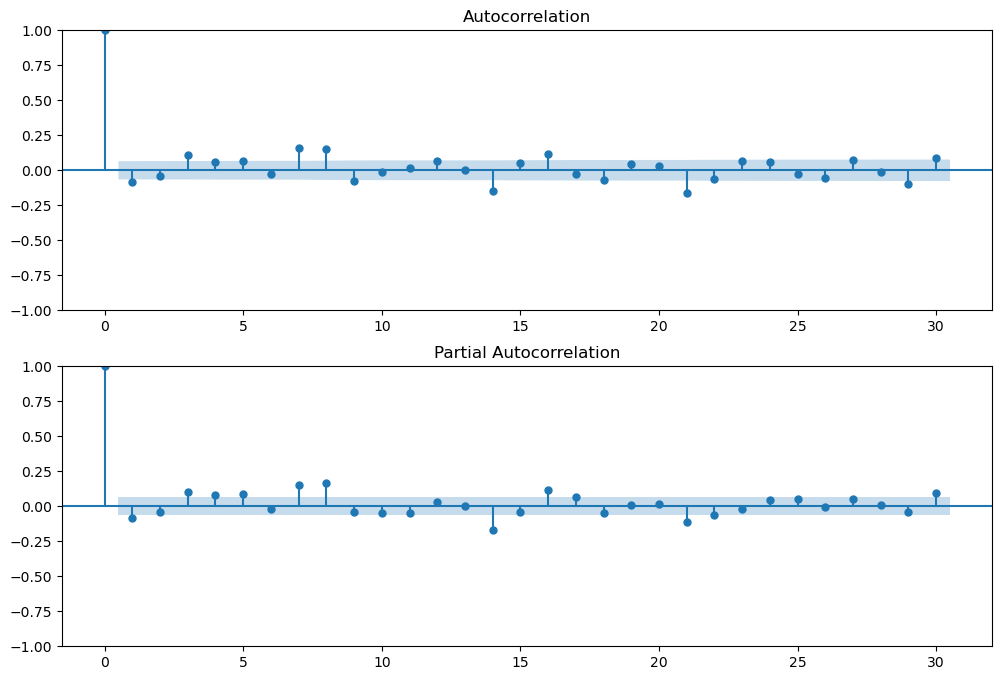

In [15]:
True_price_diff.plot()
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(True_price_diff, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(True_price_diff, lags=30, ax=ax2, method='ywm')

Now that we have seen that there is autocorrelation in the white noise, we apply a ARMA model on the TS

In [38]:
#===========================================================================
# estimate ARMA 
#===========================================================================
ar_order = [0, 1, 2, 3, 4, 5]
d_order = [0]
ma_order = [0, 1, 2, 3, 4]
arma_res = [list(orders) for orders in product(ar_order, d_order, ma_order)]
#     pprint.pprint(arma_res)

# sm.tsa.arima.model.ARIMA
for order in arma_res:
    print('fitting: ar:{} -d:{} - ma:{}'.format(*order)) 
    try:
        arma_model = sm.tsa.arima.ARIMA(True_price_diff, order=order).fit()
        order.extend([arma_model.aic / 1e3, arma_model.bic / 1e3])
    except Exception as exception:
        print(exception.__str__())
        order.extend([np.NaN, np.NaN])
    
res = pd.DataFrame(arma_res, columns = ['ar_order', 'd_order', 'ma_order', 'aic', 'bic'])
print('criterion\n', res)

fitting: ar:0 -d:0 - ma:0
fitting: ar:0 -d:0 - ma:1
fitting: ar:0 -d:0 - ma:2
fitting: ar:0 -d:0 - ma:3
fitting: ar:0 -d:0 - ma:4
fitting: ar:1 -d:0 - ma:0
fitting: ar:1 -d:0 - ma:1
fitting: ar:1 -d:0 - ma:2
fitting: ar:1 -d:0 - ma:3
fitting: ar:1 -d:0 - ma:4
fitting: ar:2 -d:0 - ma:0
fitting: ar:2 -d:0 - ma:1


c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


fitting: ar:2 -d:0 - ma:2
fitting: ar:2 -d:0 - ma:3
fitting: ar:2 -d:0 - ma:4


c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


fitting: ar:3 -d:0 - ma:0
fitting: ar:3 -d:0 - ma:1
fitting: ar:3 -d:0 - ma:2


c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


fitting: ar:3 -d:0 - ma:3


c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


fitting: ar:3 -d:0 - ma:4


c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


fitting: ar:4 -d:0 - ma:0
fitting: ar:4 -d:0 - ma:1
fitting: ar:4 -d:0 - ma:2


c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\graci\anaconda3\Lib\site-packa

fitting: ar:4 -d:0 - ma:3


c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


fitting: ar:4 -d:0 - ma:4


c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


fitting: ar:5 -d:0 - ma:0
fitting: ar:5 -d:0 - ma:1
fitting: ar:5 -d:0 - ma:2
fitting: ar:5 -d:0 - ma:3


c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


fitting: ar:5 -d:0 - ma:4
criterion
     ar_order  d_order  ma_order        aic        bic
0          0        0         0  10.002979  10.012579
1          0        0         1   9.998455  10.012855
2          0        0         2  10.000230  10.019431
3          0        0         3   9.988172  10.012173
4          0        0         4   9.989449  10.018250
5          1        0         0   9.998863  10.013263
6          1        0         1  10.000396  10.019597
7          1        0         2   9.981856  10.005857
8          1        0         3   9.967564   9.996365
9          1        0         4   9.969468  10.003069
10         2        0         0   9.999075  10.018275
11         2        0         1   9.996041  10.020042
12         2        0         2   9.968600   9.997401
13         2        0         3   9.968384  10.001986
14         2        0         4   9.967232  10.005633
15         3        0         0   9.990926  10.014926
16         3        0         1   9.971609  1

c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [39]:
res = sm.tsa.arima.ARIMA(True_price_diff, order=(1,0,1)).fit()
res
print(res.summary())
res.aic

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  898
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -4996.198
Date:              lun., 30 déc. 2024   AIC                          10000.396
Time:                        19:15:56   BIC                          10019.597
Sample:                    02-01-1950   HQIC                         10007.732
                         - 11-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.6772      1.938      3.446      0.001       2.879      10.475
ar.L1          0.0463      0.138      0.337      0.736      -0.223       0.316
ma.L1         -0.1332      0.137     -0.973      0.3

10000.3959942793

We then run a ARCH test on the residuals to make sure that we have homoskedacity

In [43]:
residus = res.resid

In [44]:
#===========================================================================
# ARCH tests 
#===========================================================================

n_autocor = 5
sm.stats.diagnostic.acorr_ljungbox(residus, lags=[n_autocor])
#We have heteroskedacity

,lb_stat,lb_pvalue
5,22.788173,0.000371


We run a GARCH model on the residuals

Iteration:      1,   Func. Count:      6,   Neg. LLF: 26943.993991501935
Iteration:      2,   Func. Count:     12,   Neg. LLF: 3708891.0233844817
Iteration:      3,   Func. Count:     20,   Neg. LLF: 5322.151346932704
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4025.596957886177
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5917.212123254679
Iteration:      6,   Func. Count:     37,   Neg. LLF: 3972.751660279334
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3945.3540891981784
Iteration:      8,   Func. Count:     47,   Neg. LLF: 4040.9187387882585
Iteration:      9,   Func. Count:     53,   Neg. LLF: 3926.027993311649
Iteration:     10,   Func. Count:     59,   Neg. LLF: 3885.416232760813
Iteration:     11,   Func. Count:     65,   Neg. LLF: 3874.8957650093703
Iteration:     12,   Func. Count:     71,   Neg. LLF: 3865.8792057344563
Iteration:     13,   Func. Count:     77,   Neg. LLF: 3841.7407375697485
Iteration:     14,   Func. Count:     83,   Neg. LLF: 375

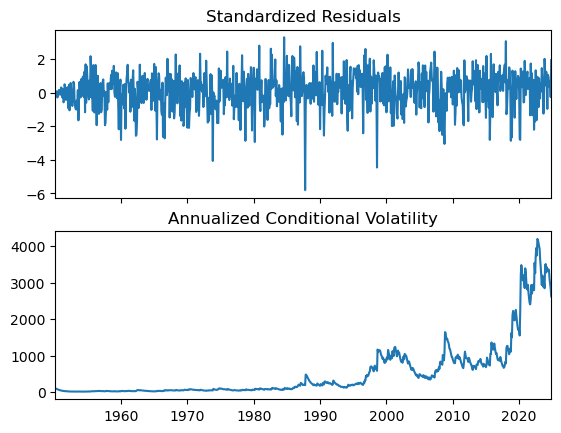

In [48]:
garch_res = arch_model(residus, p=1, o=0, q=1, dist='normal').fit()
print(garch_res.summary())
fig = garch_res.plot(annualize='D')

Forecast